In [1]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3

C:\Users\Physics\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [3]:
Sample = ['0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames', '0.02mgmlDNA_Buffer_49fps_20exp_8000frames','0.02mgmlDNA_Buffer_99fps_10exp_8000frames']

In [6]:
# different ROIs and the video number, change samNumber based upon the number of videos taken for the condition
ROI = ['0', '128', '256', '384', '512', '640', '768', '896']
samNumber = ['1','2','3','4','5','6','7','8']
ss = 0
num = 0

In [7]:
# We only need to load this because of the dts
data_d = "D:\\AllVideos\\"
data_f = Sample[num]+"_"+samNumber[ss]+"_MMStack_Pos0.ome_"+ROI[0]+"_BH_128x128_FFTDIFFS_dts_ravs.p"
dat = pickle.load(open(data_d + data_f,'r'))
dts  = dat['dts']

In [27]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 17.5
px = 0.189
imDimension = 128
q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px))
times = dts/framerate

In [8]:
#Load in the pickle files
data_dir = "D:\\AllVideos\\allResults2\\"
data_file = "allResults_"+Sample[num]+"_"+samNumber[ss]+".p"

Ana_data = pickle.load(open(data_dir + data_file, 'r'))

<Container object of 3 artists>

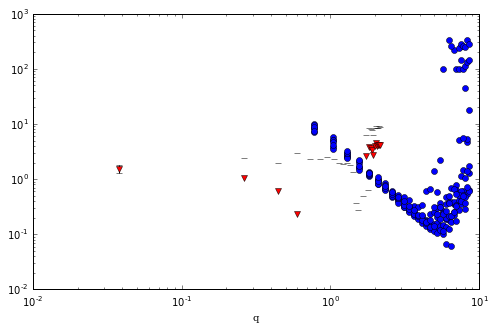

In [49]:
%matplotlib inline
mpld3.enable_notebook()

tau = np.zeros([7,63]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
#fitparams = np.zeros([63,7])
for i in range(7):
    fitparams = Ana_data['fitparams'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.set_xlabel("q", fontdict=font_plt_ax)

nt = np.zeros([7,31])
for i in range(7):
    nt[i] = ddm.newt(tau[i,2:-30],alph[i,2:-30])
    ax.loglog(q[3:-30], ddm.newt(tau[i,2:-30],alph[i,2:-30]),'bo')

ntav = np.mean(nt, axis=0)
ntstd = np.std(nt,axis=0)

ax.loglog

<Container object of 3 artists>

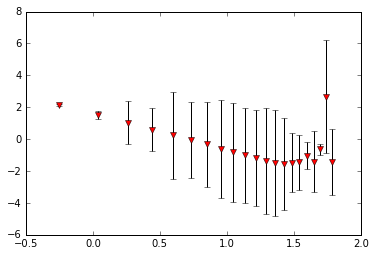

In [52]:
%matplotlib inline
mpld3.enable_notebook()

#fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
plt.errorbar(np.log(q[3:-40]), np.log(ntav[:-10]), yerr=np.log(ntstd[:-10]), xerr=None, fmt ='rv', ecolor = 'k')

In [ ]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
#ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-30], ddm.newt(tau[2:-30],alph[2:-30]),'bo')
#ax.loglog(q[3:-30], ddm.newt(tau2[2:-30],alph2[2:-30]),'rv')
diffusion_coeff = 0.25
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
adiffusion_coeff = 0.25
ax.plot(q[3:-1], (1./adiffusion_coeff) * 1./(q[3:-1]**2.3), '--k')
ax.set_xlabel("q", fontdict=font_plt_ax)

In [ ]:
def DiffCoef (tau, StretchExp, qrange, qmin, qmax):
    nt = ddm.newt(tau, StretchExp)
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean()

def Diff_Fit(qrange, taurange, qmin, qmax, StExp):
    step1 = DiffCoef(taurange, StExp, qrange, qmin, qmax)
    fit1 = (1./step1) * 1./(qrange**2)
    return fit1, step1
    
#Need to fix the function so the it will fit the data
#define a function to plot the results

def plot_results(qmin = q[2], qmax = q[10]):
    qs = q[3:-1]
    taus = tau[:,2:-1]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(qs, tau[:,2:-1], 'ro')
    ax.loglog(qs, ddm.newt(taus ,alph[2:-1]),'bo')
    fits = Diff_Fit(qs,taus, qmin, qmax, alph[2:-1])
    ax.plot(qs, fits[0],  '-k')
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("q", fontdict=font_plt_ax)
    ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)

In [ ]:
interact(plot_results, qmin = (q[2], q[8]), qmax = (q[9], q[20]), continuous_update=False)

In [ ]:
print AvgROIs
avgDiffCoeff = np.nanmean(AvgROIs)
stdev = np.nanstd(AvgROIs)
print "Averaged diffusion coefficient is: %.3f " % (avgDiffCoeff)
print "Standard deviation is: %.3f " % (stdev)
allResults['DiffCoeffROIs'] = AvgROIs
allResults['avgDiffCoeff'] = avgDiffCoeff
allResults['stdev'] = stdev